## Experiment with Gaussian mixtures using optimised kernels

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import math
import torch.distributions as dists
from scem import loss, util, kernel, net, stein, cpdkernel
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import dirname, join
import ksdmom.sampler as samp
from collections import namedtuple

In [4]:
torch.manual_seed(101)

In [5]:
results_path = './results/mixture'
problem = 'Gaussian_opt'

In [6]:
dir_path = (join(results_path, problem))
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [7]:
font = {
    'family' : 'serif',
#     'weight' : 'bold',
    'size'   : 24
}
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.usetex'] = True
plt.rc('font', **font)
plt.rc('lines', linewidth=3, markersize=10)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


### Distributions

In [8]:
class Normal:
    def __init__(self, m, s):
        self.m = m 
        self.s = s
    
    def den(self, X):
        m = self.m
        s = self.s 
        
        den = torch.exp(-torch.sum((X-m)**2, axis=1)/(2*s**2))
        den /= (2*math.pi*s**2)**(d/2)
        return den
    
    def log_den(self, X):
        m = self.m
        s = self.s
        ld = -torch.sum((X-m)**2, axis=1)/(2*s**2)
        ld -= d/2 * torch.log(torch.tensor(2*math.pi*s**2))
        return ld
    
    def score(self, X):
        m = self.m 
        s = self.s
        return -(X-m) / s**2
    
    def sample(self, n):
        m = self.m
        d = len(m)
        return m + self.s * torch.randn(n, d)
    
class MixNormal:
    def __init__(self, m1, m2, s1, s2, mweights):
        self.m1 = m1
        self.m2 = m2
        self.s1 = s1
        self.s2 = s2
        self.n1 = Normal(m1, s1)
        self.n2 = Normal(m2, s2)
        self.mweights = mweights
    
    def score(self, X):
        m1 = self.m1
        m2 = self.m2
        s1 = self.s1
        s2 = self.s2
        d = len(self.m1)
        mweights = self.mweights

        logden1 = self.n1.log_den(X)
        logden2 = self.n2.log_den(X)

        score1 = -(X - m1)/(s1**2) 
        score2 = -(X - m2)/(s2**2) 
        
        post_prob1 = 1. / (1. + (mweights[1]/mweights[0])*torch.exp(logden2-logden1))
        post_prob1 = post_prob1.unsqueeze(1)
        post_prob2 = 1. - post_prob1
        sc = post_prob1*score1 + post_prob2*score2
        return sc
    
    def den(self, X):
        m1 = self.m1
        m2 = self.m2
        s1 = self.s1
        s2 = self.s2
        d = len(self.m1)
        w = self.mweights
        den1 = torch.exp(-torch.sum((X-m1)**2, axis=1)/(2*s1**2))
        den1 /= (2*math.pi*s1**2)**(d/2)
        den2 = torch.exp(-torch.sum((X-m2)**2, axis=1)/(2*s2**2))
        den2 /= (2*math.pi*s2**2)**(d/2)
        return w[0]*den1 + w[1]*den2
    
    def log_den(self, X):
        return torch.log(self.den(X))
    
    def sample(self, n):
        m = torch.distributions.Binomial(n, torch.tensor([self.mweights[0]]))        
        n1 = int(m.sample().item())
        n2 = n - n1 
        d = len(self.m1)
        X1 = self.s1*torch.randn(n1, d) + self.m1
        X2 = self.s2*torch.randn(n2, d) + self.m2
        X = torch.cat([X1, X2])
        for _ in range(100):
            idx = torch.randperm(n)
            X = X[idx]
        return X

### Optimisation-related methods

In [9]:
def power_criterion(X, S, k, weight=None, reg=1e-9):   
    n = X.shape[0]
    H = stein.ksd_gram(X, S, k)
    if weight is None:
        mean = H.mean()
        std = ((H.mean(axis=0) - mean)**2).mean()**0.5
    else:
        mean = (H @ weight).dot(weight)
        std = (((H@weight - mean)**2).dot(weight))**0.5
    loss = mean / (std + reg)
    return loss

In [10]:
def inner_loop_grid_matern(S, X, kmat_sum, gmin, gmax, grid_size=10, weight=None): 
    scales = torch.logspace(gmin, gmax, grid_size)
    losses = []
    kmat = kmat_sum.kernels[1]
    for i, scale in enumerate(scales):
        kmat.scale = scale
        loss = power_criterion(X, S, kmat_sum, weight=weight)
        losses.append(loss)
    losses = torch.tensor(losses)
    imax = losses.argmax()
    kmat.scale = scales[imax]
    return losses[imax]
    
def inner_loop_grid_imq(S, X, kimq_sum, gmin, gmax, grid_size=10, weight=None): 
    scales = torch.logspace(gmin, gmax, grid_size)
    losses = []
    kimq = kimq_sum.kernels[1]
    for i, scale in enumerate(scales):
        kimq.s2 = scale**2
        loss = power_criterion(X, S, kimq_sum, weight=weight)
        losses.append(loss)
    losses = torch.tensor(losses)
    imax = losses.argmax()
    kimq.s2 = scales[imax]**2

In [11]:
def inner_loop_grid_matern_quad(S, X, kmat_sum_quad, gmin, gmax, grid_size=10, weight=None, ):
    inner_loop_grid_matern(S, X, kmat_sum_quad.k1, gmin, gmax, grid_size, weight=weight)
    
def inner_loop_grid_imq_vanilla(S, X, kimq, gmin, gmax, grid_size=10, weight=None): 
    scales = torch.logspace(gmin, gmax, grid_size)
    losses = []
    for i, scale in enumerate(scales):
        kimq.s2 = scale**2
        loss = power_criterion(X, S, kimq_sum, weight=weight)
        losses.append(loss)
    losses = torch.tensor(losses)
    imax = losses.argmax()
    kimq.s2 = scales[imax]**2
    
def inner_loop_grid_timq(S, X, timq, gmin, gmax, grid_size=10, weight=None):
    scales = torch.logspace(gmin, gmax, grid_size)
    losses = []
    kimq = timq.k1
    for i, scale in enumerate(scales):
        kimq.s2 = scale**2
        loss = power_criterion(X, S, kimq_sum, weight=weight)
        losses.append(loss)
    losses = torch.tensor(losses)
    imax = losses.argmax()
    kimq.s2 = scales[imax]**2

In [12]:
d = 5
m1 = -30*torch.ones(d)
m2 = -10*torch.ones(d)
s1 = 1.
s2 = 1.
target = MixNormal(m1, m2, s1, s2, 0.5*(torch.ones(2)))
model = MixNormal(m1, m2, s1, s2, torch.tensor([0.2, 0.8]))

### Define kernels

In [13]:
kimq  = kernel.KIMQ(b=-0.5)
loc = None
bias = 1e+2
klin = kernel.KLinear(scale=1, loc=loc, bias=1.)
w = kernel.MultiquadraticWeight(p=-0.5, bias=1., loc=loc)
kw = kernel.KSTWeight(w_func=w)
ktilted_lin = kernel.KSTProduct(klin, kw)
kimq_sum = kernel.KSTSumKernel([ktilted_lin, kimq])

kmat = kernel.KMatern(scale=1)
kmat_sum = kernel.KSTSumKernel([ktilted_lin, kmat])

w_ = kernel.MultiquadraticWeight(p=(1.)/2, bias=bias, loc=loc)
kw_ = kernel.KSTWeight(w_func=w_)
kmat_sum_quad = kernel.KSTProduct(kmat_sum, kw_)

w_ = kernel.MultiquadraticWeight(p=1., bias=bias, loc=loc)
kw_ = kernel.KSTWeight(w_func=w_)
timq = kernel.KSTProduct(kimq, kw_)

kernels = {
#     'IMQ': kimq, 
    'IMQ-sum': kimq_sum, 
    'Mat-sum': kmat_sum,
#     'Mat-sum-quad': kmat_sum_quad,
#     'tilted-imq': timq,
}

optims = {
    'IMQ': inner_loop_grid_imq_vanilla,
    'IMQ-sum': inner_loop_grid_imq,
    'Mat-sum': inner_loop_grid_matern,
    'Mat-sum-quad': inner_loop_grid_matern_quad,
    'tilted-imq': inner_loop_grid_timq,
}

### Compute KSD

In [14]:
n = 500
rep = 100
n_ps = 30
ps = torch.linspace(0., 0.5, n_ps)
rerun = False
separate = False
vstat = True

In [15]:
data = np.empty([len(kernels), rep, n_ps])
losses = {
    k: loss.KSD(v, target.score) 
    for k, v in kernels.items()
}

if not separate:
    weight = None

for l_i, (key, l) in enumerate(losses.items()):
    filename = (
        '{}_separate.npy'.format(key) if separate else
        '{}.npy'.format(key)
    )
    print(filename)
    path = os.path.join(dir_path, filename)
    if os.path.exists(path) and not rerun:
        tmp = np.load(path)
        data[l_i] = tmp[:rep]
    else:
        optim_fn = optims[key]
        for j, p in enumerate(ps):
            print(j, p)
            model = MixNormal(m1, m2, s1, s2, torch.tensor([p, 1-p]))
            for i in range(rep):
                if separate:
                    X1 = s1*torch.randn(n//2, d) + m1
                    X2 = s2*torch.randn(n//2, d) + m2
                    X = torch.vstack([X1, X2])
                    weight = torch.tensor([p]*(n//2) + [1-p]*(n//2))/(n//2)
                else:
                    X = model.sample(n)
                S = target.score(X)
                optim_fn(S, X, kernels[key], -3, 3, grid_size=20, weight=weight)
                data[l_i, i, j] = l.loss(X, vstat=vstat, weight=weight, ignore_diag=False).detach().numpy()
        result = data[l_i]
#         np.save(path, result)               

IMQ-sum.npy
0 tensor(0.)
1 tensor(0.0172)
2 tensor(0.0345)
3 tensor(0.0517)
4 tensor(0.0690)
5 tensor(0.0862)
6 tensor(0.1034)
7 tensor(0.1207)
8 tensor(0.1379)
9 tensor(0.1552)
10 tensor(0.1724)
11 tensor(0.1897)
12 tensor(0.2069)
13 tensor(0.2241)
14 tensor(0.2414)
15 tensor(0.2586)
16 tensor(0.2759)
17 tensor(0.2931)
18 tensor(0.3103)
19 tensor(0.3276)
20 tensor(0.3448)
21 tensor(0.3621)
22 tensor(0.3793)
23 tensor(0.3966)
24 tensor(0.4138)
25 tensor(0.4310)
26 tensor(0.4483)
27 tensor(0.4655)
28 tensor(0.4828)
29 tensor(0.5000)
Mat-sum.npy
0 tensor(0.)
1 tensor(0.0172)
2 tensor(0.0345)
3 tensor(0.0517)
4 tensor(0.0690)
5 tensor(0.0862)
6 tensor(0.1034)
7 tensor(0.1207)
8 tensor(0.1379)
9 tensor(0.1552)
10 tensor(0.1724)
11 tensor(0.1897)
12 tensor(0.2069)
13 tensor(0.2241)
14 tensor(0.2414)
15 tensor(0.2586)
16 tensor(0.2759)
17 tensor(0.2931)
18 tensor(0.3103)
19 tensor(0.3276)
20 tensor(0.3448)
21 tensor(0.3621)
22 tensor(0.3793)
23 tensor(0.3966)
24 tensor(0.4138)
25 tensor(0.43

In [16]:
Format = namedtuple('Format', ['color', 'linestyle',])
label_format_tuples = {
    'IMQ': ("IMQ ", Format('C1', '-', )),
    'IMQ-sum': ('IMQ sum (lin.) ', Format('C2', '--',)),
    'Mat-sum': ('Matérn sum (lin.) ', Format('C7', '-.',)),
    'Mat-sum-quad': ('Matérn sum (quad.) $\\theta=0$', Format('C7', ':',)),
    'tilted-imq': ('Tilted IMQ (quad.)', Format('C11', ':',)),
}

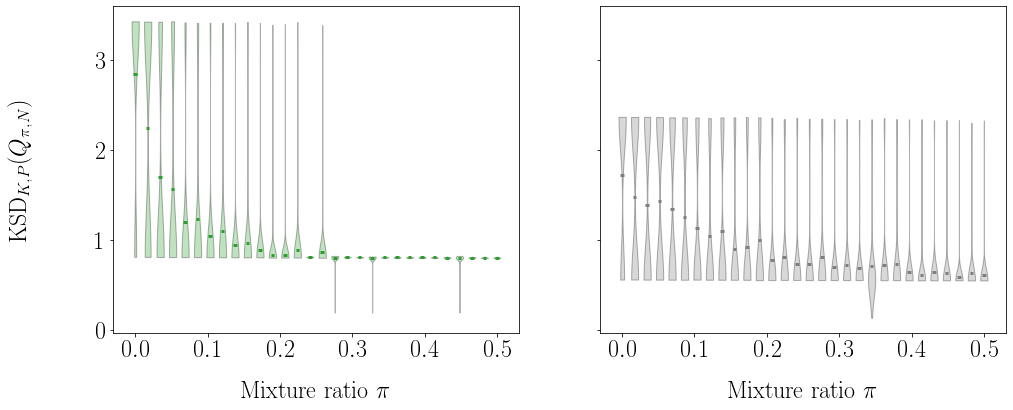

In [19]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True,
                         figsize=(8*2, 6))
labels = []
for ki, key in enumerate(losses.keys()):
    ax = axes[ki]
    ax.set_yscale('linear')

    label = ax.set_xlabel('Mixture ratio $\pi$', fontsize = 24)
    ax.xaxis.set_label_coords(0.5, -0.15)
    if ki == 0:
        label = ax.set_ylabel('$\\mathrm{KSD}_{K,P}(Q_{\pi,N})$', fontsize = 24)
#         label.set_rotation(0)
#         ax.yaxis.set_label_coords(-0.1, 1.05)    
        ax.yaxis.set_label_coords(-0.2, 0.5)    

#     ax.set_yticks([1e-1, 1e+0, 1e+1, 1e+2])
    ax.set_xticks([0.1*i for i in range(0, 5+1)])


    label = label_format_tuples[key][0]
    fmt = label_format_tuples[key][1]
#     ax.plot(ps, data[ki].mean(axis=0), label=label, 
#             color=fmt.color, linestyle=fmt.linestyle)
#     y = data[ki].mean(axis=0)
#     y = np.percentile(data[ki], q=50, axis=0)
#     ax.plot(ps, y, color=fmt.color, label=label, linestyle=fmt.linestyle)
#     error_low = (y - np.percentile(data[ki], q=5, axis=0))
#     error_high = np.percentile(data[ki], q=95, axis=0)-y
#     errors = np.vstack([error_low, error_high])
#     ax.errorbar(ps, y, yerr=data[ki].std(axis=0),
#     ax.errorbar(ps, y, yerr=errors,
#                 color=fmt.color, label=label, linestyle=fmt.linestyle, alpha=0.3)
    violin_parts = ax.violinplot(data[ki], ps.detach().numpy(), showmeans=True, showextrema=False, 
                                 widths=0.01)
    plt.setp(violin_parts['bodies'], facecolor=fmt.color, edgecolor='black', alpha=0.3)
    plt.setp(violin_parts['cmeans'], edgecolor=fmt.color)
    labels.append((mpatches.Patch(color=fmt.color), label))
    

# ax.legend(bbox_to_anchor=(1.75,1.), ncol=4)
# plt.legend(*zip(*labels), bbox_to_anchor=(3.75,1.), ncol=4)
# ax.set_yscale('log')
#ax.yaxis.set_minor_locator(LogLocator(numticks=10))
 
plt.savefig('ksd_gauss_mixture_opt_imq_vs_matern.pdf', bbox_inches='tight')